In [74]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
from saliency.gradcam import GradCam, superimpose, fuse_layers, grad_cam_plus

CLASS_NAMES = ["healthy", "wssv"]
AUTOTUNE = tf.data.AUTOTUNE
CONFIG = dict(
    epochs=100,
    learning_rate=1e-4,
    batch_size=64,
    img_shape=(224, 224),
    input_shape=(224, 224, 3),
    num_classes=2,
    dropout_rate=0.5,
    es_patience=10,
    seed_value=42,
)

TEST_DIR = "dataset-augmented/test"
CLASS_NAMES = ["healthy", "wssv"]

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=CONFIG["seed_value"],
    image_size=CONFIG["img_shape"],
    batch_size=CONFIG["batch_size"],
    label_mode="categorical",
).prefetch(buffer_size=AUTOTUNE)

Found 13 files belonging to 2 classes.


In [85]:
def create_model():
    base_model = tf.keras.applications.EfficientNetV2B0(
        input_shape=CONFIG["input_shape"],
        include_top=False,
        classes=CONFIG["num_classes"],
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=CONFIG["input_shape"])
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(rate=CONFIG["dropout_rate"], seed=CONFIG["seed_value"])(
        x
    )
    outputs = tf.keras.layers.Dense(units=CONFIG["num_classes"], activation="softmax")(
        x
    )

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    )

    return model


checkpoint_filepath = "checkpoints_efficientnetv2b0"
latest = tf.train.latest_checkpoint(checkpoint_filepath)

model = create_model()
model.load_weights(latest).expect_partial()

test_images = []
test_labels = []
for X, y in test_dataset.as_numpy_iterator():
    test_images.append(X)
    test_labels.append(y)

test_images = np.concatenate(test_images)
test_labels = np.argmax(np.concatenate(test_labels), axis=1)

In [105]:
all_layers = [
    layer.name
    for layer in reversed(model.get_layer("efficientnetv2-b0").layers)
    if len(layer.output_shape) == 4
    and (
        layer.__class__.__name__ == "Activation"
        or isinstance(layer, tf.keras.layers.DepthwiseConv2D)
        or isinstance(layer, tf.keras.layers.Conv2D)
    )
]

# remove layers with "se"
all_layers = [layer for layer in all_layers if "se" not in layer]

predictions = model.predict(test_images).argmax(axis=1)

grad_cam_images = []
for i, layer in enumerate(test_images):
    fused = fuse_layers(
        all_layers, model.get_layer("efficientnetv2-b0"), test_images[i], True
    )
    grad_cam_images.append(fused)

1/1 [==============================] - 0s 70ms/step


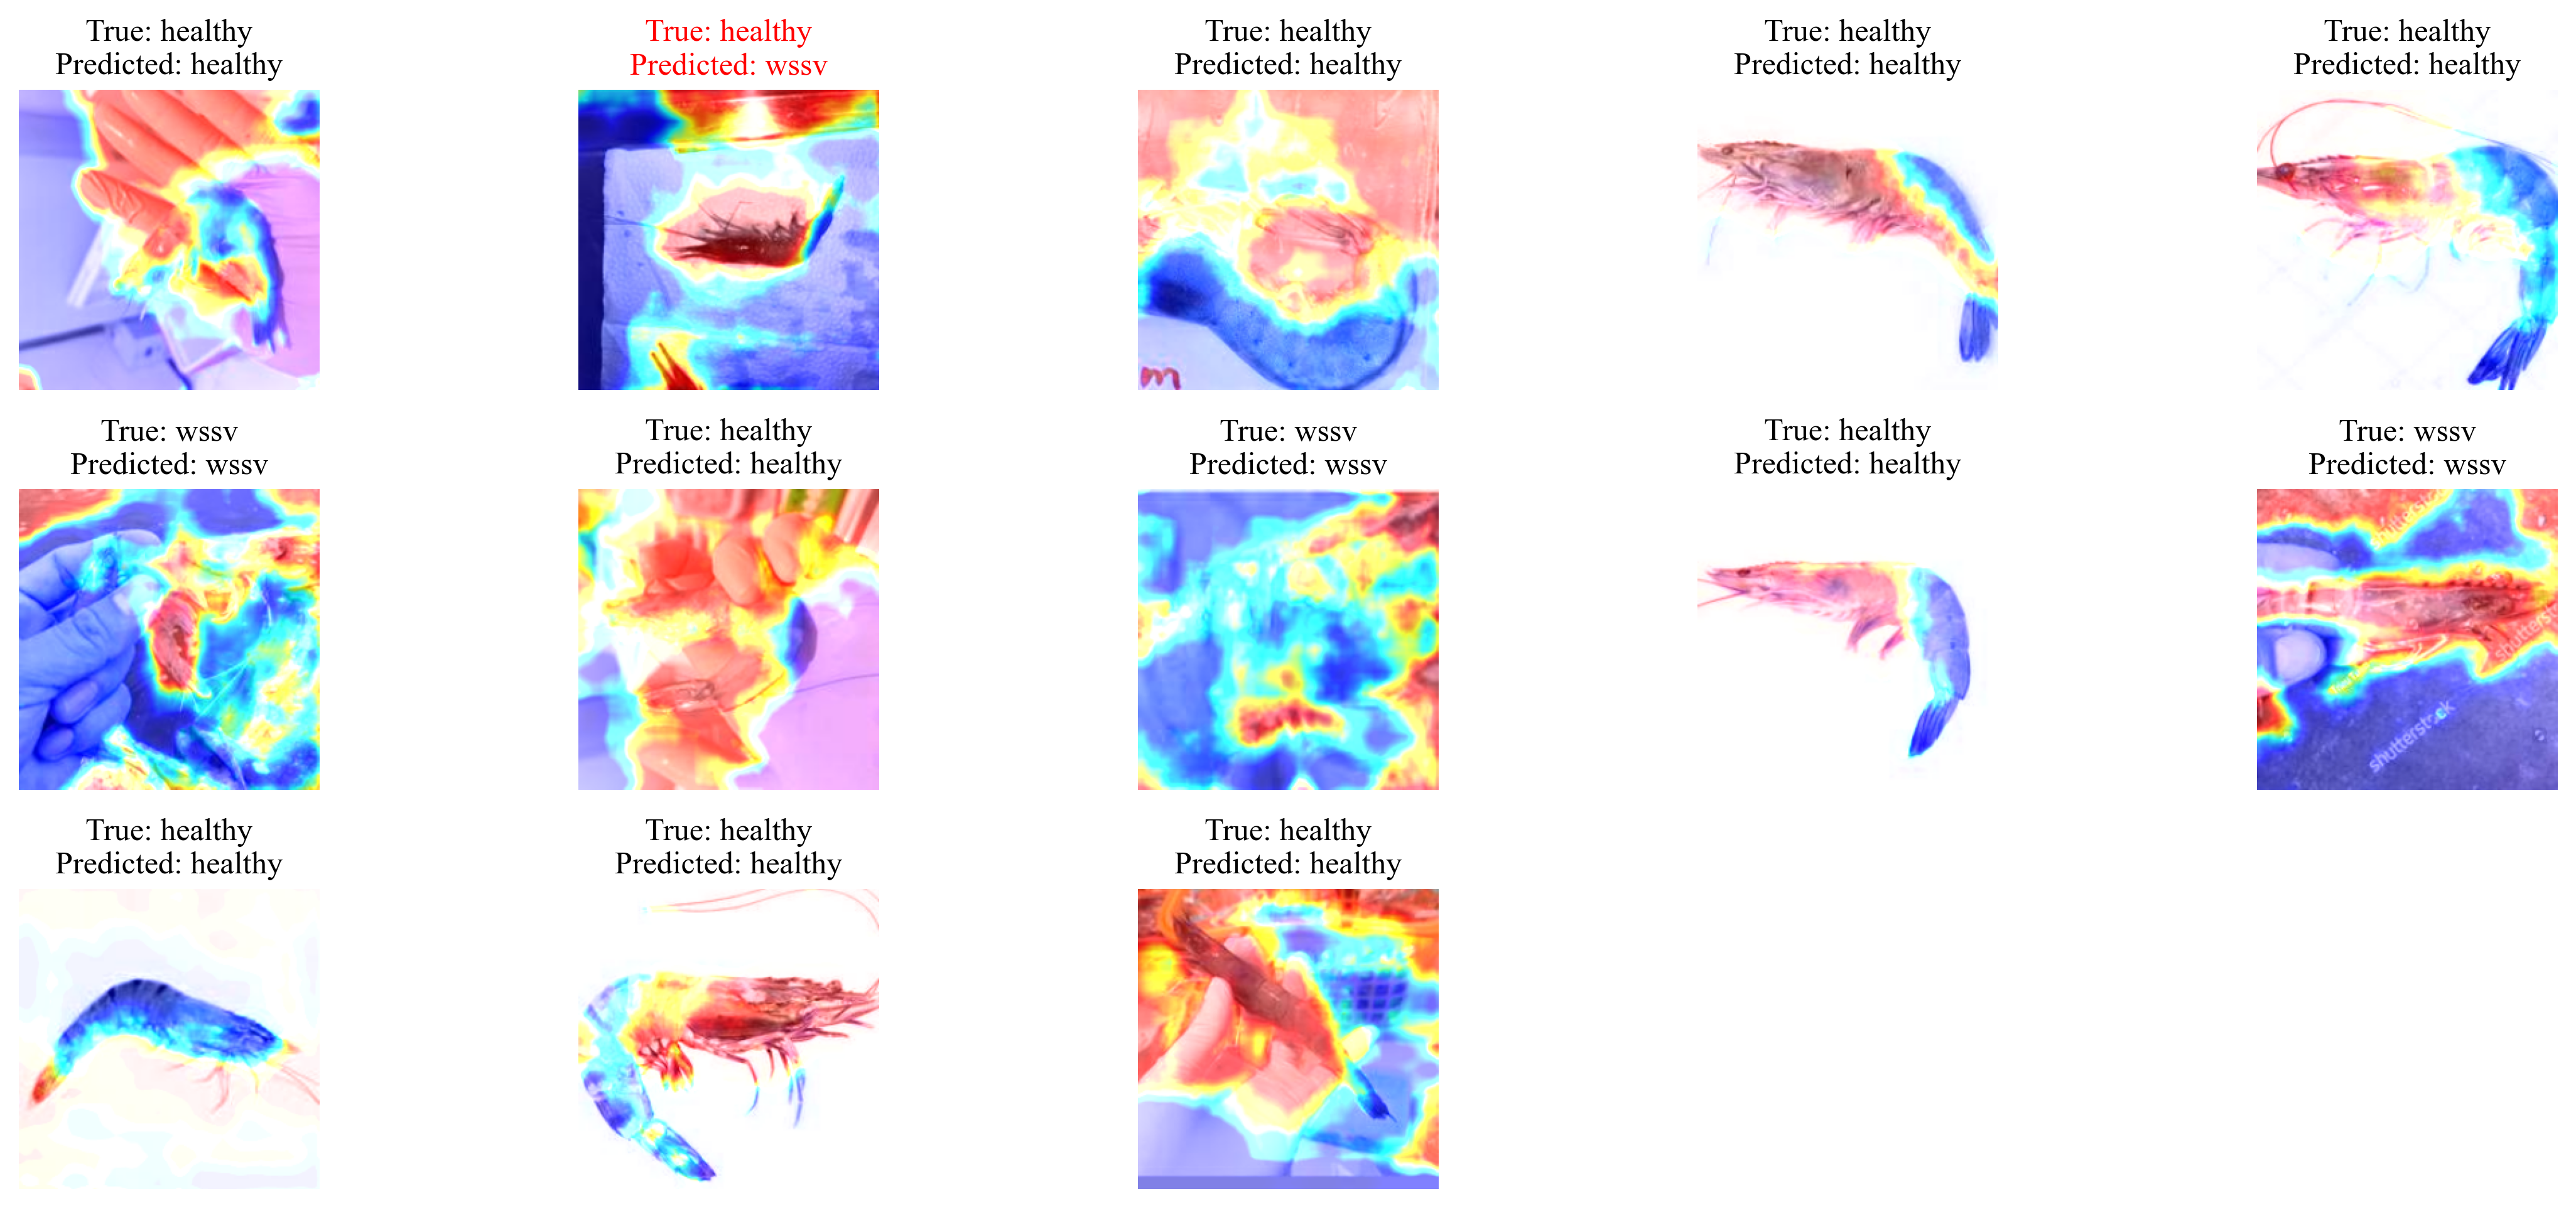

In [106]:
# Change font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(15, 15), dpi=300)
for i, image in enumerate(grad_cam_images):
    ax = plt.subplot(7, 5, i + 1)
    if CLASS_NAMES[test_labels[i]] is not CLASS_NAMES[predictions[i]]:
        misclassified = True
    else:
        misclassified = False

    plt.imshow(image)
    plt.title(
        f"True: {CLASS_NAMES[test_labels[i]]}\nPredicted: {CLASS_NAMES[predictions[i]]}",
        color="red" if misclassified else "black",
    )

    plt.axis("off")

plt.tight_layout()